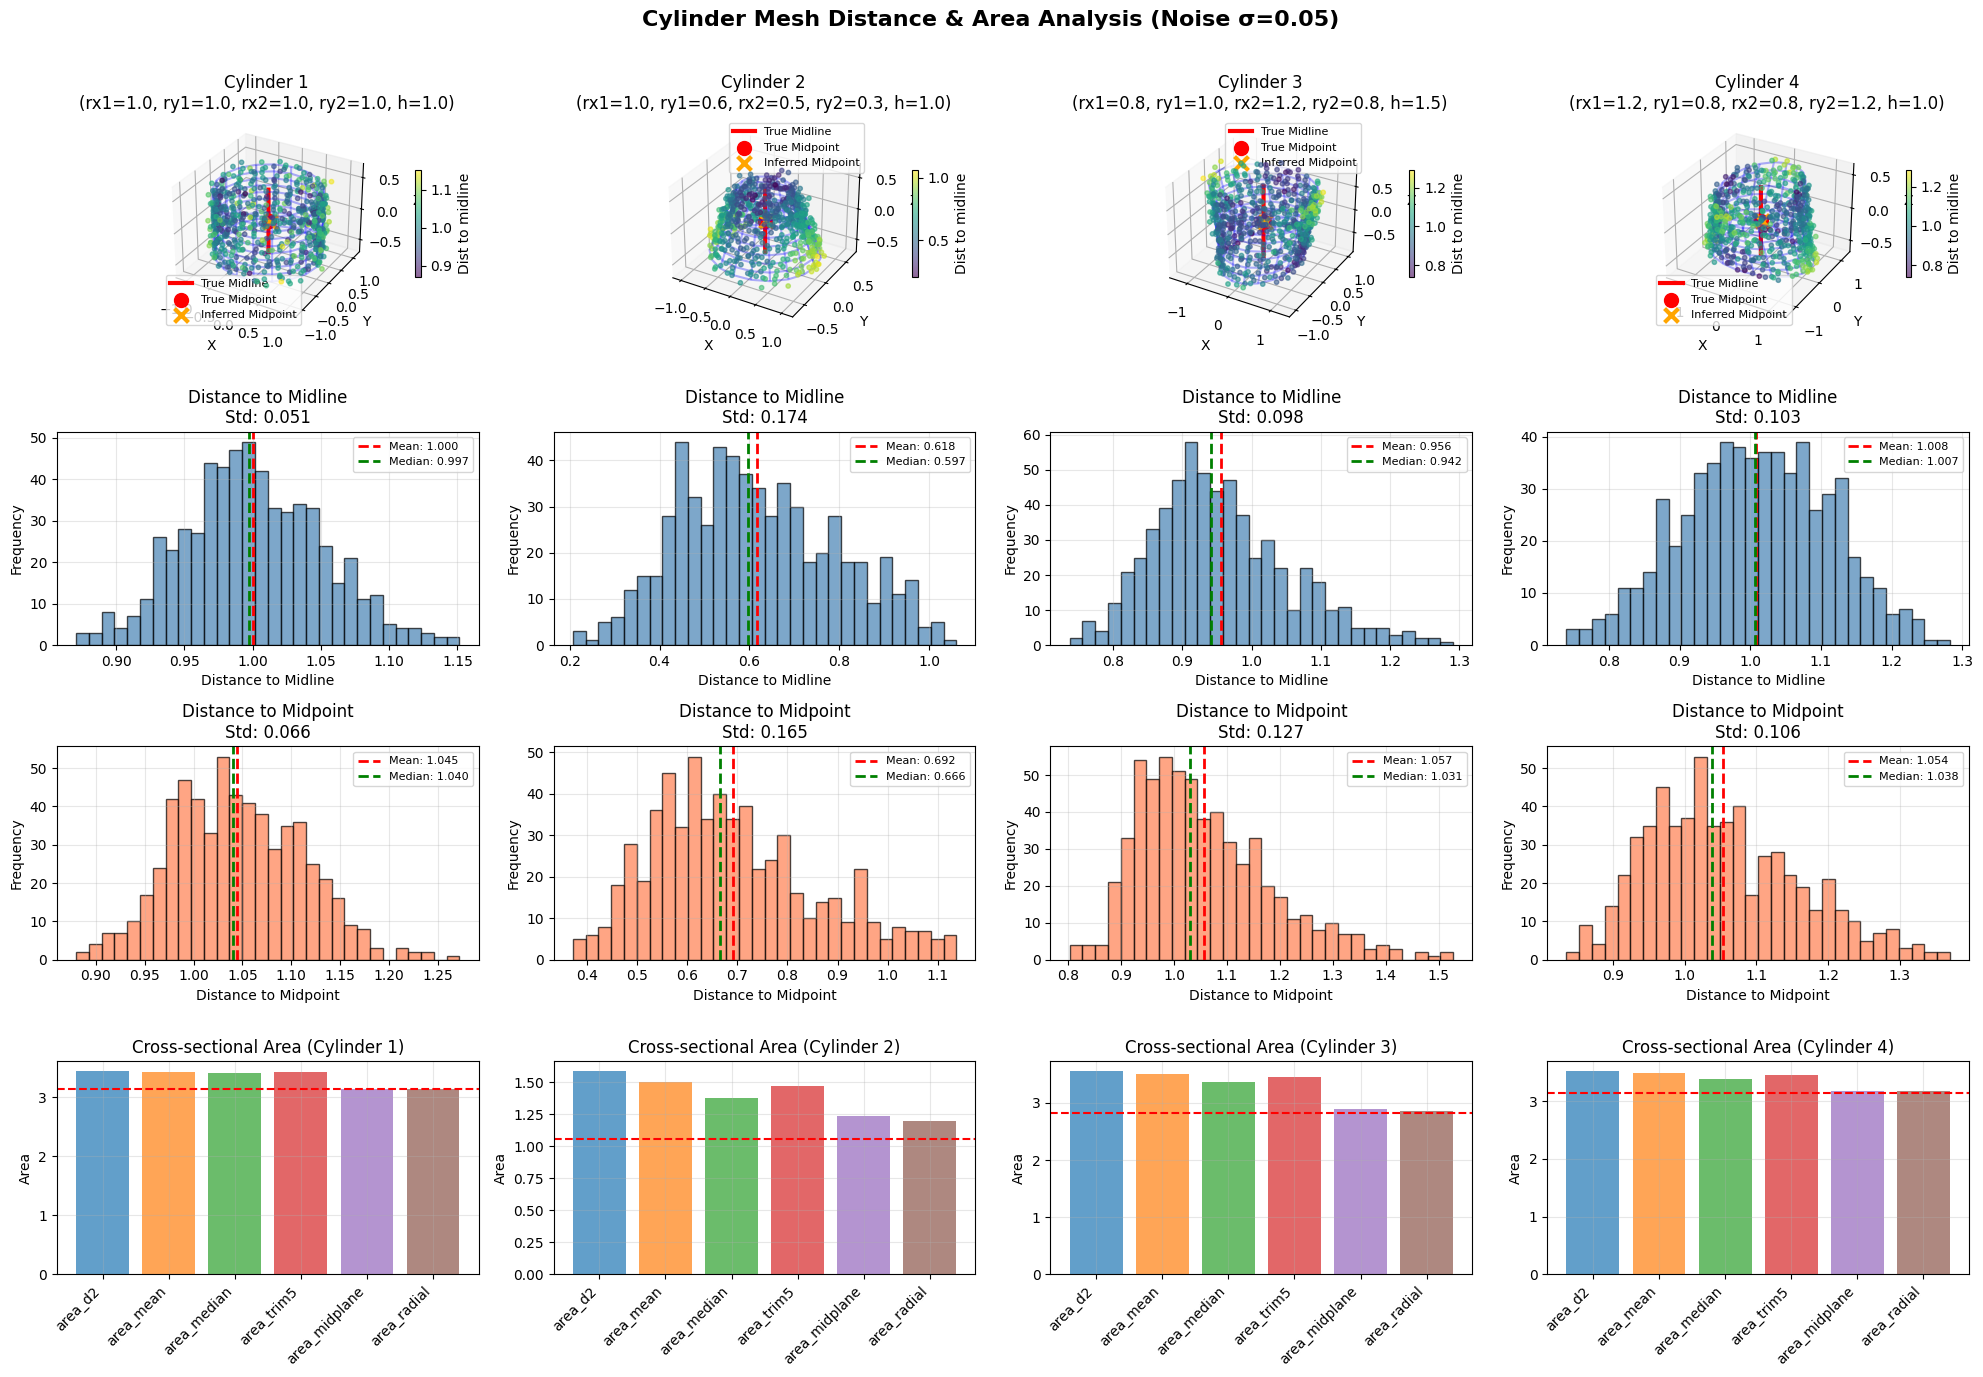

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class EllipticalCone:
    """A cylinder/cone with elliptical cross-sections (different radii in x and y directions)."""

    def __init__(self, rx1, ry1, rx2, ry2, height, center=(0, 0, 0)):
        """
        Parameters:
        - rx1, ry1: radii in x and y directions at bottom (z=0)
        - rx2, ry2: radii in x and y directions at top (z=height)
        - height: height of cylinder
        - center: center point (x, y, z)
        """
        self.rx1 = rx1
        self.ry1 = ry1
        self.rx2 = rx2
        self.ry2 = ry2
        self.height = height
        self.center = np.array(center)

        # Midline: vertical line through center
        self.midline_start = self.center - np.array([0, 0, height/2])
        self.midline_end = self.center + np.array([0, 0, height/2])
        self.midpoint = self.center

    def radii_at_z(self, z):
        """Get rx and ry at a given z coordinate (relative to center)."""
        z_rel = z + self.height/2  # Convert to 0-height range
        t = z_rel / self.height  # Parameter from 0 to 1
        rx = self.rx1 + (self.rx2 - self.rx1) * t
        ry = self.ry1 + (self.ry2 - self.ry1) * t
        return rx, ry

    def generate_surface_mesh(self, n_theta=30, n_z=20, noise_std=0.0):
        """
        Generate mesh points on the surface with optional Gaussian noise.

        Parameters:
        - n_theta: number of points around circumference
        - n_z: number of points along height
        - noise_std: standard deviation of Gaussian noise

        Returns:
        - points: (N, 3) array of mesh points
        """
        theta = np.linspace(0, 2*np.pi, n_theta)
        z_vals = np.linspace(-self.height/2, self.height/2, n_z)

        points = []
        for z in z_vals:
            rx, ry = self.radii_at_z(z)
            for th in theta:
                x = rx * np.cos(th)
                y = ry * np.sin(th)

                # Add Gaussian noise
                if noise_std > 0:
                    noise = np.random.normal(0, noise_std, 3)
                    point = np.array([x, y, z]) + noise + self.center
                else:
                    point = np.array([x, y, z]) + self.center

                points.append(point)

        return np.array(points)

    def distance_to_midline(self, points):
        """
        Compute distance from points to the cylinder's midline.

        The midline is a vertical line through the center.
        Distance is the perpendicular distance in the xy-plane.
        """
        # For a vertical midline, distance is just the radial distance in xy-plane
        points_rel = points - self.center
        distances = np.sqrt(points_rel[:, 0]**2 + points_rel[:, 1]**2)
        return distances

    def distance_to_midpoint(self, points):
        """
        Compute Euclidean distance from points to the cylinder's midpoint.
        """
        distances = np.linalg.norm(points - self.midpoint, axis=1)
        return distances

    def cross_sectional_area_at_center(self):
        """
        Compute the cross-sectional area at the center (z=0, midpoint).
        For an ellipse: A = π * rx * ry
        """
        rx_center, ry_center = self.radii_at_z(0)  # z=0 is at the center
        area = np.pi * rx_center * ry_center
        return area, rx_center, ry_center

    def get_wireframe(self, n_theta=20, n_z=10):
        """Generate wireframe for visualization."""
        theta = np.linspace(0, 2*np.pi, n_theta)
        z_vals = np.linspace(-self.height/2, self.height/2, n_z)

        x_wire = []
        y_wire = []
        z_wire = []

        for z in z_vals:
            rx, ry = self.radii_at_z(z)
            x_wire.append(rx * np.cos(theta) + self.center[0])
            y_wire.append(ry * np.sin(theta) + self.center[1])
            z_wire.append(np.full_like(theta, z + self.center[2]))

        return np.array(x_wire), np.array(y_wire), np.array(z_wire)


def infer_midpoint_from_mesh(mesh_points):
    """
    Infer the midpoint from mesh data by taking the centroid.
    This is the Maximum Likelihood Estimator assuming symmetric sampling.
    """
    return np.mean(mesh_points, axis=0)


def estimate_cross_sectional_area(mesh_points, inferred_midpoint):
    """
    Estimate cross-sectional area from distances to inferred midpoint.

    For a cylinder with elliptical cross-section at the midpoint:
    - Points on surface at height z=0 are at distance sqrt(rx^2*cos^2(theta) + ry^2*sin^2(theta))
    - Points at other heights z have additional distance contribution from z
    - Distance^2 = rx^2*cos^2(theta) + ry^2*sin^2(theta) + z^2

    For points uniformly distributed on surface:
    - E[distance^2] = E[rx^2*cos^2(theta) + ry^2*sin^2(theta)] + E[z^2]
    - E[rx^2*cos^2(theta) + ry^2*sin^2(theta)] = (rx^2 + ry^2)/2  (for uniform theta)
    - For uniform z in [-h/2, h/2]: E[z^2] = h^2/12

    So: E[d^2] = (rx^2 + ry^2)/2 + h^2/12

    However, we want the area A = pi*rx*ry at z=0.

    Approach 1: Use only points near the midplane (z ≈ 0)
    Approach 2: Use all points but account for z-variation
    """
    distances = np.linalg.norm(mesh_points - inferred_midpoint, axis=1)

    # Method 1: Naive estimator using mean squared distance
    # This will be biased upward due to z-variation
    mean_d2 = np.mean(distances**2)
    area_d2 = mean_d2 * np.pi
    area_mean = np.mean(distances)**2 * np.pi
    area_median = np.median(distances)**2 * np.pi
    area_trim5 = np.mean(np.sort(distances)[int(0.05*len(distances)):int(0.95*len(distances))])**2 * np.pi

    # Method 2: Select points near midplane (within 10% of height range)
    z_coords = mesh_points[:, 2] - inferred_midpoint[2]
    z_range = np.max(z_coords) - np.min(z_coords)
    midplane_mask = np.abs(z_coords) < 0.1 * z_range

    if np.sum(midplane_mask) > 10:  # Need enough points
        distances_midplane = distances[midplane_mask]
        mean_r_midplane = np.mean(distances_midplane)
        # For ellipse, mean radius relates to area, but not simply
        # Approximation: assume circular, then A ≈ pi * r_mean^2
        area_estimate_midplane = np.pi * mean_r_midplane**2
    else:
        area_estimate_midplane = None

    # Method 3: Use distances in xy-plane only (project to midplane)
    xy_points = mesh_points[:, :2]
    inferred_midpoint_xy = inferred_midpoint[:2]
    radial_distances = np.linalg.norm(xy_points - inferred_midpoint_xy, axis=1)
    mean_r_radial = np.mean(radial_distances)
    area_estimate_radial = np.pi * mean_r_radial**2

    return {
        'area_d2' : area_d2,
        'area_mean': area_mean,
        'area_median': area_median,
        'area_trim5': area_trim5,
        'area_midplane': area_estimate_midplane,
        'area_radial': area_estimate_radial,
    }


def simulate_cylinders(cylinder_params, noise_std=0.0, n_theta=30, n_z=20):
    """
    Simulate multiple cylinders and compute distance distributions.

    Parameters:
    - cylinder_params: list of (rx1, ry1, rx2, ry2, height) tuples
    - noise_std: standard deviation of Gaussian noise
    - n_theta, n_z: mesh resolution

    Returns:
    - cylinders: list of EllipticalCone objects
    - all_dist_midline: list of distance-to-midline arrays
    - all_dist_midpoint: list of distance-to-midpoint arrays
    - all_mesh_points: list of mesh point arrays
    """
    cylinders = []
    all_dist_midline = []
    all_dist_midpoint = []
    all_mesh_points = []

    for rx1, ry1, rx2, ry2, height in cylinder_params:
        cyl = EllipticalCone(rx1, ry1, rx2, ry2, height)
        mesh_points = cyl.generate_surface_mesh(n_theta, n_z, noise_std)
        dist_midline = cyl.distance_to_midline(mesh_points)
        dist_midpoint = cyl.distance_to_midpoint(mesh_points)

        cylinders.append(cyl)
        all_dist_midline.append(dist_midline)
        all_dist_midpoint.append(dist_midpoint)
        all_mesh_points.append(mesh_points)

    return cylinders, all_dist_midline, all_dist_midpoint, all_mesh_points


def plot_results(cylinders, all_dist_midline, all_dist_midpoint, all_mesh_points, noise_std):
    """Create visualization of cylinders, distance distributions, and area estimates."""
    n_cylinders = len(cylinders)

    # Compute area estimates and midpoint errors beforehand
    area_data = []
    for cyl, mesh_points in zip(cylinders, all_mesh_points):
        true_area, rx_c, ry_c = cyl.cross_sectional_area_at_center()
        inferred_midpoint = infer_midpoint_from_mesh(mesh_points)
        area_estimates = estimate_cross_sectional_area(mesh_points, inferred_midpoint)
        area_data.append((true_area, area_estimates))

    # Create figure with 4 rows
    fig = plt.figure(figsize=(5 * n_cylinders, 14))

    # --- Row 1: 3D plots ---
    for idx, (cyl, dist_midline, mesh_points) in enumerate(zip(cylinders, all_dist_midline, all_mesh_points)):
        ax = fig.add_subplot(4, n_cylinders, idx + 1, projection='3d')

        x_wire, y_wire, z_wire = cyl.get_wireframe()
        ax.plot_wireframe(x_wire, y_wire, z_wire, alpha=0.3, color='blue')

        scatter = ax.scatter(mesh_points[:, 0], mesh_points[:, 1], mesh_points[:, 2],
                             c=dist_midline, cmap='viridis', s=10, alpha=0.6)

        ax.plot([cyl.midline_start[0], cyl.midline_end[0]],
                [cyl.midline_start[1], cyl.midline_end[1]],
                [cyl.midline_start[2], cyl.midline_end[2]], 'r-', linewidth=3, label='True Midline')
        ax.scatter(*cyl.midpoint, color='red', s=100, marker='o', label='True Midpoint')

        inferred_mp = infer_midpoint_from_mesh(mesh_points)
        ax.scatter(*inferred_mp, color='orange', s=100, marker='x', linewidths=3, label='Inferred Midpoint')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Cylinder {idx+1}\n(rx1={cyl.rx1}, ry1={cyl.ry1}, rx2={cyl.rx2}, ry2={cyl.ry2}, h={cyl.height})')
        ax.legend(fontsize=8)
        plt.colorbar(scatter, ax=ax, label='Dist to midline', shrink=0.5, pad=0.1)

    # --- Row 2: Distance to midline histograms ---
    for idx, (cyl, distances) in enumerate(zip(cylinders, all_dist_midline)):
        ax = fig.add_subplot(4, n_cylinders, n_cylinders + idx + 1)
        ax.hist(distances, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
        ax.axvline(np.mean(distances), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {np.mean(distances):.3f}')
        ax.axvline(np.median(distances), color='green', linestyle='--',
                   linewidth=2, label=f'Median: {np.median(distances):.3f}')
        ax.set_xlabel('Distance to Midline')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distance to Midline\nStd: {np.std(distances):.3f}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # --- Row 3: Distance to midpoint histograms ---
    for idx, (cyl, distances) in enumerate(zip(cylinders, all_dist_midpoint)):
        ax = fig.add_subplot(4, n_cylinders, 2 * n_cylinders + idx + 1)
        ax.hist(distances, bins=30, alpha=0.7, edgecolor='black', color='coral')
        ax.axvline(np.mean(distances), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {np.mean(distances):.3f}')
        ax.axvline(np.median(distances), color='green', linestyle='--',
                   linewidth=2, label=f'Median: {np.median(distances):.3f}')
        ax.set_xlabel('Distance to Midpoint')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distance to Midpoint\nStd: {np.std(distances):.3f}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # --- Row 4: True vs Estimated Cross-sectional Areas ---
    for idx, (cyl, (true_area, estimates)) in enumerate(zip(cylinders, area_data)):
        ax = fig.add_subplot(4, n_cylinders, 3 * n_cylinders + idx + 1)

        for i, (method, area) in enumerate(estimates.items()):
            ax.bar(i, area, alpha=0.7, label=method)
            ax.set_ylabel('Area')
            ax.set_title(f'Cross-sectional Area (Cylinder {idx+1})')
        ax.axhline(true_area, color='red', linestyle='--')

        ax.set_xticks(range(len(estimates)))
        ax.set_xticklabels(list(estimates.keys()), rotation=45, ha='right')
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Cylinder Mesh Distance & Area Analysis (Noise σ={noise_std})',
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# Main simulation
if __name__ == "__main__":
    # Define cylinder parameters: (rx1_bottom, ry1_bottom, rx2_top, ry2_top, height)
    cylinder_params = [
        (1.0, 1.0, 1.0, 1.0, 1.0),    # Perfect circular cylinder
        (1.0, 0.6, 0.5, 0.3, 1.0),    # Elliptical tapered cone
        (0.8, 1.0, 1.2, 0.8, 1.5),    # Elliptical with twist
        (1.2, 0.8, 0.8, 1.2, 1.0),    # Ellipse orientation flip
    ]

    # Simulate with noise
    noise_std = 0.05
    cylinders, all_dist_midline, all_dist_midpoint, all_mesh_points = simulate_cylinders(
        cylinder_params,
        noise_std=noise_std,
        n_theta=30,
        n_z=20
    )

    # Print statistics
    # print("Cylinder Distance Statistics and Area Estimation:")
    # print("=" * 90)
    # for idx, (cyl, dist_ml, dist_mp, mesh_points) in enumerate(zip(cylinders, all_dist_midline,
    #                                                                  all_dist_midpoint, all_mesh_points)):
    #     true_area, rx_c, ry_c = cyl.cross_sectional_area_at_center()
    #
    #     # Infer midpoint from data
    #     inferred_midpoint = infer_midpoint_from_mesh(mesh_points)
    #     midpoint_error = np.linalg.norm(inferred_midpoint - cyl.midpoint)
    #
    #     # Estimate area
    #     area_estimates = estimate_cross_sectional_area(mesh_points, inferred_midpoint)
    #
    #     print(f"\nCylinder {idx+1} (rx1={cyl.rx1}, ry1={cyl.ry1}, rx2={cyl.rx2}, ry2={cyl.ry2}, h={cyl.height}):")
    #     print(f"  TRUE cross-sectional area at center: {true_area:.4f} (rx={rx_c:.4f}, ry={ry_c:.4f})")
    #     print(f"  Midpoint inference error: {midpoint_error:.6f}")
    #     print(f"  ESTIMATED areas:")
    #     if area_estimates['area_midplane'] is not None:
    #         error_midplane = 100 * (area_estimates['area_midplane'] - true_area) / true_area
    #         print(f"    Midplane method: {area_estimates['area_midplane']:.4f} (error: {error_midplane:+.2f}%)")
    #     print(f"    Radial projection method: {area_estimates['area_radial']:.4f} (error: {100*(area_estimates['area_radial']-true_area)/true_area:+.2f}%)")
    #     print(f"    Mean radial distance: {area_estimates['mean_r_radial']:.4f} (true mean: {(rx_c+ry_c)/2:.4f})")
    #     print(f"  Distance to Midline:")
    #     print(f"    Mean: {np.mean(dist_ml):.4f}  Std: {np.std(dist_ml):.4f}  Min: {np.min(dist_ml):.4f}  Max: {np.max(dist_ml):.4f}")
    #     print(f"  Distance to Midpoint:")
    #     print(f"    Mean: {np.mean(dist_mp):.4f}  Std: {np.std(dist_mp):.4f}  Min: {np.min(dist_mp):.4f}  Max: {np.max(dist_mp):.4f}")

    # Visualize
    plot_results(cylinders, all_dist_midline, all_dist_midpoint, all_mesh_points, noise_std)